This is based on the [EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43) notebook, modified for Pytorch. The original notebook is implemented in Tensorflow.

* Change to pytorch's Dataset and Dataloader
* Use efficientnet_b0 from torchvision
* Use pytorch lightning for building the model and training
* Inference using Trainer on multiple GPUs (DDP strategy) requires adding predictions gathering code, otherwise it will hang waiting for other nodes. So the raw pytorch's inference loop is used in the CV part. This needs to be done after training all the folds since the manual torch's GPU device initialization can't be mixed with lightning's DDP strategy.

In [1]:
import os
import sys
import gc
sys.path.append('../kaggle-kl-div')

from kaggle_kl_div import score

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pytorch_lightning as pl
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GroupKFold

In [ ]:
VER = 5
# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = '/kaggle/input/hms-efficientnetb0-pt-ckpts/'

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = True

# Data Loading

In [2]:
train_csv = pd.read_csv('../train.csv')
TARGETS = train_csv.columns[-6:]

print('Train shape:', train_csv.shape )
print('Targets', list(TARGETS))
train_csv.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
def get_non_overlap(df_csv):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # same results as Chris's notebook

    tgt_list = TARGETS.tolist()

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
    }

    for t in tgt_list:
        agg_dict[t] = 'sum'

    agg_dict['expert_consensus'] = 'first'

    train = df_csv.groupby('eeg_id').agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spec_id', 'spec_offset_min', 'spec_offset_max', 'patient_id'] + tgt_list + ['target']
    train = train.reset_index(drop=False)

    train[tgt_list] = train[tgt_list].div(train[tgt_list].sum(axis=1), axis='index')

    return train

df_train = get_non_overlap(train_csv)

print(df_train.shape)

df_train.head(10)

(17089, 12)


,eeg_id,spec_id,spec_offset_min,spec_offset_max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.000000,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.000000,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.000000,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,Other
5,1629671,2036345030,0.0,160.0,37481,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,Seizure
6,1895581,128369999,1138.0,1138.0,47999,0.076923,0.000000,0.00,0.000000,0.076923,0.846154,Other
7,2061593,320962633,1450.0,1450.0,23828,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,Other
8,2078097,2074135650,3342.0,3342.0,61174,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,Other
9,2366870,1232582129,0.0,30.0,23633,0.000000,0.333333,0.00,0.000000,0.000000,0.666667,Other


In [14]:
df_specs = pd.read_parquet('../all_specs.parquet')
all_specs = {int(k): v.drop(['spec_id', 'time'], axis=1).values for k, v in df_specs.groupby('spec_id')}

In [15]:
all_specs

{1000086677: array([[2.868e+01, 5.399e+01, 6.763e+01, ..., 5.000e-02, 4.000e-02,
         5.000e-02],
        [2.964e+01, 3.896e+01, 4.401e+01, ..., 6.000e-02, 6.000e-02,
         6.000e-02],
        [8.890e+00, 9.020e+00, 1.636e+01, ..., 1.400e-01, 1.300e-01,
         1.400e-01],
        ...,
        [2.400e-01, 1.900e-01, 2.100e-01, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [9.900e-01, 1.230e+00, 1.370e+00, ..., 1.000e-02, 1.000e-02,
         1.000e-02],
        [1.810e+00, 2.110e+00, 1.950e+00, ..., 1.000e-02, 1.000e-02,
         1.000e-02]], dtype=float32),
 1000189855: array([[5.61, 6.05, 8.5 , ..., 0.35, 0.4 , 0.31],
        [6.96, 7.6 , 8.97, ..., 0.27, 0.27, 0.28],
        [5.58, 5.89, 6.23, ..., 0.05, 0.07, 0.08],
        ...,
        [1.24, 1.76, 1.85, ..., 0.05, 0.05, 0.03],
        [2.51, 2.44, 2.53, ..., 0.11, 0.06, 0.05],
        [2.27, 2.53, 2.55, ..., 0.05, 0.05, 0.03]], dtype=float32),
 1000317312: array([[ 9.74, 10.24, 11.01, ...,  0.05,  0.07,  0.06],
 

In [16]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}


class DataGenerator(Dataset):
    
    def __init__(self, data, specs=all_specs, mode='train'): 

        self.data = data
        self.mode = mode
        self.specs = specs
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self, indices):
        X, y = self._generate_data(indices)
     
        if self.mode == 'train':
            return list(zip(X, y))
        else:
            return X
    
    def _generate_data(self, indexes):
        # This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample
        # 4 channels: LL, LR, RL, RR
        # Note: only kaggle spectrograms are used --> only 4 channels 
        X = np.zeros( (len(indexes), 128, 256, 4), dtype='float32')
        y = np.zeros( (len(indexes), 6), dtype='float32')
        img = np.ones( (128, 256), dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode == 'test': 
                r = 0
            else: 
                r = int((row['spec_offset_min'] + row['spec_offset_max'])//4)

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                # --> r: rows; k: frequency bands (100 bands per channel)
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            if self.mode != 'test':
                y[j,] = row[TARGETS]
            
        return X, y

In [17]:
dataset = DataGenerator(df_train, all_specs, mode='train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

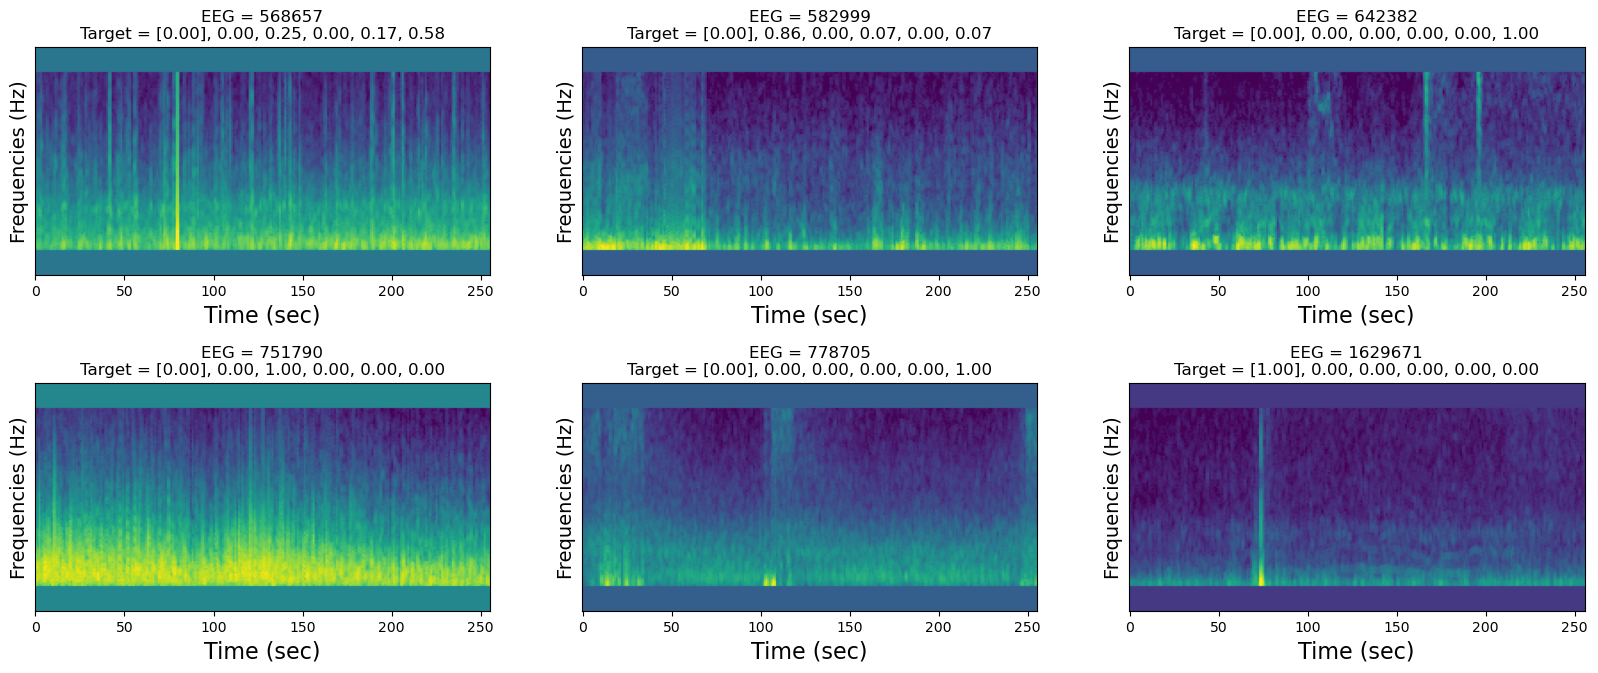

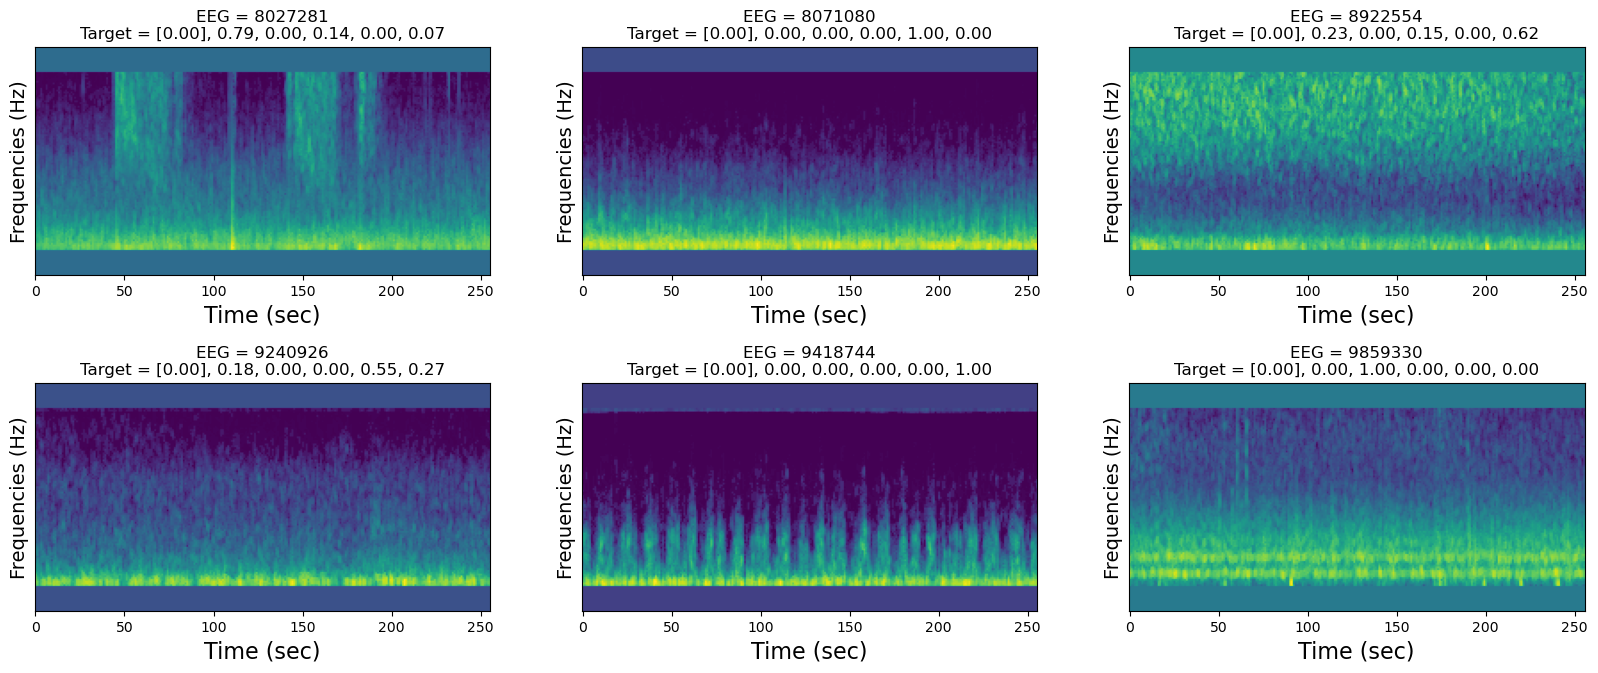

In [18]:
ROWS = 2
COLS = 3
BATCHES = 2

for i, (x, y) in enumerate(dataloader):
    plt.figure(figsize=(20, 8))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS + k + 1)
            t = y[j*COLS + k]
            img = torch.flip(x[j*COLS+k, :, :, 0], (0,))
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}]'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            eeg = df_train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i == BATCHES-1:
        break

In [19]:
del dataset, dataloader
gc.collect()

30973

# Training

In [24]:
WEIGHTS_FILE = '../models/efficientnet_b0_rwightman-7f5810bc.pth'
class EEGEffnetB0(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.base_model = efficientnet_b0()
        self.base_model.load_state_dict(torch.load(WEIGHTS_FILE))
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, 6, dtype=torch.float32)
        self.prob_out = nn.Softmax()
        
    def forward(self, x):
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)
        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=1)
        
        if USE_KAGGLE_SPECTROGRAMS & USE_EEG_SPECTROGRAMS:
            x = torch.concat([x1, x2], dim=2)
        elif USE_EEG_SPECTROGRAMS:
            x = x2
        else:
            x = x1
        x = torch.concat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        
        out = self.base_model(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        out = F.log_softmax(out, dim=1)
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        loss = kl_loss(out, y)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return F.softmax(self(batch), dim=1)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [27]:
all_oof = []
all_true = []
valid_loaders = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):  
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_ds = DataGenerator(df_train.iloc[train_index],  all_specs, mode='train')
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=32, num_workers=3)
    valid_ds = DataGenerator(df_train.iloc[valid_index], all_specs, mode='valid')
    valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=64, num_workers=3)
    
    print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
    print('#'*25)
    
    trainer = pl.Trainer(max_epochs=4)
    model = EEGEffnetB0()
   
    trainer.fit(model=model, train_dataloaders=train_loader)
    trainer.save_checkpoint(f'EffNet_v{VER}_f{i}.ckpt')

    valid_loaders.append(valid_loader)
    all_true.append(df_train.iloc[valid_index][TARGETS].values)
    del trainer, model
    gc.collect()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#########################
### Fold 1
### Train size: 13671, Valid size: 3418
#########################



  | Name       | Type         | Params
--------------------------------------------
0 | base_model | EfficientNet | 4.0 M 
1 | prob_out   | Softmax      | 0     
--------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.061    Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
python(24599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.10/multip

NameError: name 'VER' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for i in range(5):
    print('#'*25)
    print(f'### Validating Fold {i+1}')

    ckpt_file = f'EffNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VER}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    with torch.inference_mode():
        for val_batch in valid_loaders[i]:
            val_batch = val_batch.to(device)
            oof = torch.softmax(model(val_batch), dim=1).cpu().numpy()
            all_oof.append(oof)
    del model
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

In [ ]:
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)

# Inference

In [ ]:
del all_eegs, spectrograms
gc.collect()

test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

In [ ]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms2 = {}
for i, f in enumerate(files2):
    if i % 100 == 0:
        print(i, ', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:, 1:].values
    
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id': 'spec_id'}, axis=1)

In [ ]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]


# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret


def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

In [ ]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}

print('Converting Test EEG to Spectrograms...'); print()
for i, eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i < DISPLAY)
    all_eegs2[eeg_id] = img

In [ ]:
# INFER EFFICIENTNET ON TEST
preds = []
test_ds = EEGDataset(test, mode='test', specs=spectrograms2, eeg_specs=all_eegs2)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

for i in range(5):
    print('#'*25)
    print(f'### Testing Fold {i+1}')

    ckpt_file = f'EffNet_v{VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/EffNet_v{VER}_f{i}.ckpt'
    model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
    model.to(device).eval()
    fold_preds = []

    with torch.inference_mode():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
            fold_preds.append(pred)
        fold_preds = np.concatenate(fold_preds)

    preds.append(fold_preds)

pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

In [ ]:
sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

In [ ]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)